In [1]:
import pandas as pd
# read in files
# Read UK_df.csv as pandas dataframe
original_UK_dialogue = pd.read_csv('UK_df.csv')
original_UK_politeness = pd.read_csv('UK_direct_df.csv')
original_UK_narrator = pd.read_csv('UK_narrator_df.csv')
original_US_dialogue = pd.read_csv('US_df.csv')
original_US_politeness = pd.read_csv('US_direct_df.csv')
original_US_narrator = pd.read_csv('US_narrator_df.csv')
dataframes = [original_UK_dialogue, original_UK_politeness, original_UK_narrator, original_US_dialogue, original_US_politeness, original_US_narrator]
def elim_outliers(df):
    # dropped Unnamed: 0 column
    df.drop(columns=['Unnamed: 0'], inplace=True)
    filtered_df = df.loc[(df['response'] > 95) | (df['response'] < 5)]
    for id in df['person_id'].unique():
        if len(filtered_df[filtered_df['person_id'] == id])/len(df[df['person_id'] == id])>0.8:
            df.drop(df[df['person_id'] == id].index, inplace=True)
    df['predicate Z-score'] = df.groupby(['person_id','predicate'])['response'].transform(lambda x: (x - x.mean()) / x.std())
    # if has_intensifier = no then change 'intensifier' to 'none'
    df.loc[df['has intensifier?'] == 'no', 'intensifier'] = 'none'
    return df
for i in range(len(dataframes)):
    dataframes[i] = elim_outliers(dataframes[i])
dialogue = pd.concat([dataframes[0], dataframes[3]])
politeness = pd.concat([dataframes[1], dataframes[4]])
UK_dialogue = dataframes[0]
US_dialogue = dataframes[3]
UK_politeness = dataframes[1]
US_politeness = dataframes[4]

# end of reading in data
#-------------------------------------------------------------------------------

# compute U_soc (social Utility)
U_soc_data = politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
UK_U_soc_data = UK_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()
US_U_soc_data = US_politeness.groupby(['intensifier','predicate'])['predicate Z-score'].mean().to_dict()

In [2]:
from memo import memo
import jax
import jax.numpy as np
from enum import IntEnum, auto

Define constants

In [3]:
epsilon = 0.01
infty = 10000000
utterences =list(U_soc_data.keys())
state_values = np.arange(-2.8,2.8,0.28)
S = np.arange(0,20,1)

Define params to iterate

In [4]:
theta_to_test = np.arange(0,20,1)
possible_inf_terms = np.arange(0,5,0.5)
possible_soc_terms = np.arange(0,5,0.5)
costs = np.arange(0,5,0.5)

Grid search (code from demo-rsa.py)

In [7]:
class W(IntEnum):  # utterance space
    # borings
    none_boring = auto(0)
    slightly_boring = auto()
    kind_of_boring = auto()
    quite_boring = auto()
    very_boring = auto()
    extremely_boring = auto()
    # concerneds
    none_concerned = auto()
    slightly_concerned = auto()
    kind_of_concerned = auto()
    quite_concerned = auto()
    very_concerned = auto()
    extremely_concerned = auto()
    # difficults
    none_difficult = auto()
    slightly_difficult = auto()
    kind_of_difficult = auto()
    quite_difficult = auto()
    very_difficult = auto()
    extremely_difficult = auto()
    # exhausteds
    none_exhausted = auto()
    slightly_exhausted = auto()
    kind_of_exhausted = auto()
    quite_exhausted = auto()
    very_exhausted = auto()
    extremely_exhausted = auto()
    # helpfuls
    none_helpful = auto()
    slightly_helpful = auto()
    kind_of_helpful = auto()
    quite_helpful = auto()
    very_helpful = auto()
    extremely_helpful = auto()
    # impressives
    none_impressive = auto()
    slightly_impressive = auto()
    kind_of_impressive = auto()
    quite_impressive = auto()
    very_impressive = auto()
    extremely_impressive = auto()
    # understandables
    none_understandable = auto()
    slightly_understandable = auto()
    kind_of_understandable = auto()
    quite_understandable = auto()
    very_understandable = auto()
    extremely_understandable = auto()

In [8]:
# Generate the mapping dictionary
U_soc_key_map = {w: (' '.join(w.name.split('_')[:-1]), w.name.split('_')[-1]) for w in W}
U_soc_array = np.array([U_soc_data[U_soc_key_map[W(i)]] for i in range(len(W))])
UK_U_soc_array = np.array([UK_U_soc_data[U_soc_key_map[W(i)]] for i in range(len(W))])
US_U_soc_array = np.array([US_U_soc_data[U_soc_key_map[W(i)]] for i in range(len(W))])

Construct measured_values which is an array of 42 arrays where the i'th entry is the values people reported for the i'th utterance

In [9]:
possible_literal_semantics = np.array(
    [
        np.concatenate([np.repeat(np.array([epsilon]),i),np.repeat(np.array([1]),20-i)])
        for i in range(20)
    ]
)
@jax.jit
def state_prior(s):
    return np.float32(np.exp(-state_values[s]**2/2))  # uninformative state prior doesn't matter that it doesn't add up to 1
@jax.jit
def U_soc(soc):
    return U_soc_array[soc]
@jax.jit
def UK_U_soc(soc):
    return UK_U_soc_array[soc]

@jax.jit
def US_U_soc(soc):
    return US_U_soc_array[soc]

@jax.jit
def is_costly(w):
    arr = [0, 1, 1, 1, 1, 1]*7
    return np.array(arr)[w]
@jax.jit
def L(w, s,t0,t1,t2,t3,t4,t5):  # literal likelihood L(w | s)
    intensifier_semantics = np.array([  # "hard semantics"
        possible_literal_semantics[t0],  # none
        possible_literal_semantics[t1],  # slightly 
        possible_literal_semantics[t2],  # kind of
        possible_literal_semantics[t3],  # quite
        possible_literal_semantics[t4],  # very
        possible_literal_semantics[t5],  # extremely
    ])
    return np.tile(intensifier_semantics, (7, 1))[w, s]

@memo
def L1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * U_soc(w) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
@memo
def UKL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * UK_U_soc(w) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]
@memo
def USL1[s: S, w: W](inf_term, soc_term, cost,t0,t1,t2,t3,t4,t5):
    listener: thinks[
        speaker: given(s in S, wpp=state_prior(s)),
        speaker: chooses(w in W, wpp=
            imagine[
                listener: knows(w),
                listener: chooses(s in S, wpp=L(w, s,t0,t1,t2,t3,t4,t5)) ,
                exp(inf_term * log(Pr[listener.s == s]) + 
                soc_term * US_U_soc(w) - # U_soc = listener's EU
                cost*is_costly(w)) # U_inf = listener's surprisal       
            ]
        )
    ]
    listener: observes[speaker.w] is w
    listener: chooses(s in S, wpp=Pr[speaker.s == s])
    return Pr[listener.s == s]

In [10]:
# Create a list of JAX arrays
UK_measured_values = []
for w in W:
    intensifier, predicate = U_soc_key_map[w]   
    raw_values = UK_dialogue[((UK_dialogue['intensifier'] == intensifier) & (UK_dialogue['predicate'] == predicate))]['predicate Z-score'].values
    # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
    z = [int(r/0.28)+10 for r in raw_values]
    x = [0]*len(S)
    if intensifier != 'none': # make measured_values all zero if intensifier is none
        for i in z:
            x[i] += 1
    UK_measured_values.append(x)
UK_measured_values = np.array(UK_measured_values)
# Create a list of JAX arrays
US_measured_values = []
for w in W:
    intensifier, predicate = U_soc_key_map[w]   
    raw_values = US_dialogue[((US_dialogue['intensifier'] == intensifier) & (US_dialogue['predicate'] == predicate))]['predicate Z-score'].values
    # measured_values.append(np.array([int(r/0.28)+10 for r in raw_values]))
    z = [int(r/0.28)+10 for r in raw_values]
    x = [0]*len(S)
    if intensifier != 'none': # make measured_values all zero if intensifier is none
        for i in z:
            x[i] += 1
    US_measured_values.append(x)
US_measured_values = np.array(US_measured_values)
def compute_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    P_l1 = L1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5]) # note this should be P(s|w)
    return np.sum(np.log(P_l1)*UK_measured_values.T),np.sum(np.log(P_l1)*US_measured_values.T)
def UK_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    P_l1 = UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5]) # note this should be P(s|w)
    return np.sum(np.log(P_l1)*UK_measured_values.T)
def US_soc_logloss(*params):
    thetas = params[:6]
    cost = params[6]
    inf_term = params[7]
    soc_term = params[8]
    # compute fit e.g. log_likelihood
    P_l1 = USL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5]) # note this should be P(s|w)
    return np.sum(np.log(P_l1)*US_measured_values.T)

[ 0  3 11 14 26 17 24 19  6  5 10 13  2  1  1  2  0  0  0  0]


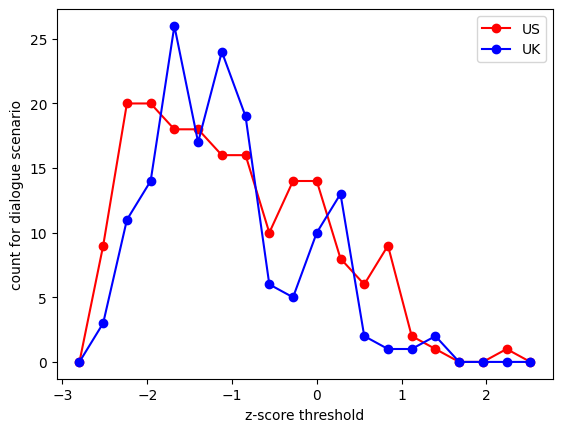

In [ ]:
# # sum rows of UK_measured_values which are same mod 6
# import numpy as np
# # plot histogram of arr
# print(np.sum(UK_measured_values[1::6],axis=0))
# import matplotlib.pyplot as plt

# plt.plot(state_values,np.sum(US_measured_values[1::6],axis=0), marker = 'o',color='r', label="US")
# plt.plot(state_values,np.sum(UK_measured_values[1::6],axis=0), marker = 'o',color='b', label="UK")
# plt.legend()
# plt.xlabel('z-score threshold')
# plt.ylabel('count for dialogue scenario')
# plt.show()


In [11]:
total_param_combos = len(costs)*len(possible_soc_terms)*len(possible_inf_terms)*len(theta_to_test)
in_repeat = total_param_combos//len(theta_to_test)
out_repeat = 1
# first_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# second_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# third_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# fourth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
# fifth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
# out_repeat = out_repeat*len(theta_to_test)
# in_repeat = in_repeat//len(theta_to_test)
sixth_thetas = np.repeat(np.tile(theta_to_test, in_repeat),out_repeat)
out_repeat = out_repeat*len(theta_to_test)
in_repeat = in_repeat//len(costs)
seventh_costs = np.repeat(np.tile(costs, in_repeat),out_repeat)
out_repeat = out_repeat*len(costs)
in_repeat = in_repeat//len(possible_inf_terms)
eighth_infs = np.repeat(np.tile(possible_inf_terms, in_repeat),out_repeat)
out_repeat = out_repeat*len(possible_inf_terms)
in_repeat = in_repeat//len(possible_soc_terms)
ninth_socs = np.repeat(np.tile(possible_soc_terms, in_repeat),out_repeat)

In [12]:
# compute UK specific result
for t1 in theta_to_test:
    all_output = []
    for t2 in theta_to_test:
        for t3 in theta_to_test:
            for t4 in theta_to_test:
                for t5 in theta_to_test:
                    output= jax.vmap(UK_soc_logloss,in_axes=(None,)*5+(0,)*4)(t1,t2,t3,t4,t5,sixth_thetas,seventh_costs,eighth_infs,ninth_socs).block_until_ready()
                    all_output.append(output)
                print(t1,t2,t3,t4)
    all_output = np.array(all_output).flatten()
    np.save(f'UK_specific_soc_feb21_{t1}.npy', all_output)
    del all_output
# compute US specific result
for t1 in theta_to_test:
    all_output = []
    for t2 in theta_to_test:
        for t3 in theta_to_test:
            for t4 in theta_to_test:
                for t5 in theta_to_test:
                    output= jax.vmap(US_soc_logloss,in_axes=(None,)*5+(0,)*4)(t1,t2,t3,t4,t5,sixth_thetas,seventh_costs,eighth_infs,ninth_socs).block_until_ready()
                    all_output.append(output)
                print(t1,t2,t3,t4)
    all_output = np.array(all_output).flatten()
    np.save(f'US_specific_soc_feb21_{t1}.npy', all_output)
    del all_output

for t1 in theta_to_test:
    # compute UK/US specific result
    UK_all_output = []
    US_all_output = []
    for t2 in theta_to_test:
        for t3 in theta_to_test:
            for t4 in theta_to_test:
                for t5 in theta_to_test:
                    UK_output,US_output = jax.vmap(compute_logloss,in_axes=(None,)*5+(0,)*4)(t1,t2,t3,t4,t5,sixth_thetas,seventh_costs,eighth_infs,ninth_socs).block_until_ready()
                    UK_all_output.append(UK_output)
                    US_all_output.append(US_output)
                print(t1,t2,t3,t4)
    # save all_output to a file
    UK_all_output = np.array(UK_all_output).flatten()
    np.save(f'UK_standard_feb21_{t1}.npy', UK_all_output)
    del UK_all_output
    US_all_output = np.array(US_all_output).flatten()
    np.save(f'US_standard_feb21_{t1}.npy', US_all_output)
    del US_all_output

0 0 0 0
0 0 0 1
0 0 0 2
0 0 0 3
0 0 0 4
0 0 0 5
0 0 0 6
0 0 0 7
0 0 0 8
0 0 0 9
0 0 0 10
0 0 0 11
0 0 0 12
0 0 0 13
0 0 0 14
0 0 0 15
0 0 0 16
0 0 0 17
0 0 0 18
0 0 0 19
0 0 1 0
0 0 1 1
0 0 1 2
0 0 1 3
0 0 1 4
0 0 1 5
0 0 1 6
0 0 1 7
0 0 1 8
0 0 1 9
0 0 1 10
0 0 1 11
0 0 1 12
0 0 1 13
0 0 1 14
0 0 1 15
0 0 1 16
0 0 1 17
0 0 1 18
0 0 1 19
0 0 2 0
0 0 2 1
0 0 2 2
0 0 2 3
0 0 2 4
0 0 2 5
0 0 2 6
0 0 2 7
0 0 2 8
0 0 2 9
0 0 2 10
0 0 2 11
0 0 2 12
0 0 2 13
0 0 2 14
0 0 2 15
0 0 2 16
0 0 2 17
0 0 2 18
0 0 2 19
0 0 3 0
0 0 3 1
0 0 3 2
0 0 3 3
0 0 3 4
0 0 3 5
0 0 3 6
0 0 3 7
0 0 3 8
0 0 3 9
0 0 3 10
0 0 3 11
0 0 3 12
0 0 3 13
0 0 3 14
0 0 3 15
0 0 3 16
0 0 3 17
0 0 3 18
0 0 3 19
0 0 4 0
0 0 4 1
0 0 4 2
0 0 4 3
0 0 4 4
0 0 4 5
0 0 4 6
0 0 4 7
0 0 4 8
0 0 4 9
0 0 4 10
0 0 4 11
0 0 4 12
0 0 4 13
0 0 4 14
0 0 4 15
0 0 4 16
0 0 4 17
0 0 4 18
0 0 4 19
0 0 5 0
0 0 5 1
0 0 5 2
0 0 5 3
0 0 5 4
0 0 5 5
0 0 5 6
0 0 5 7
0 0 5 8
0 0 5 9
0 0 5 10
0 0 5 11
0 0 5 12
0 0 5 13
0 0 5 14
0 0 5 15
0 0 5 16
0 0 5 1

KeyboardInterrupt: 

Produce graph from ideal parameters

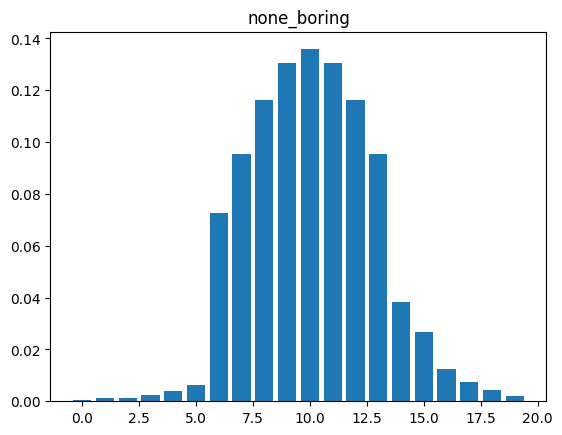

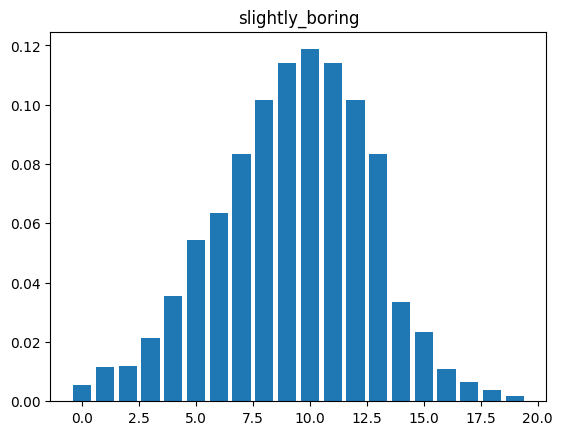

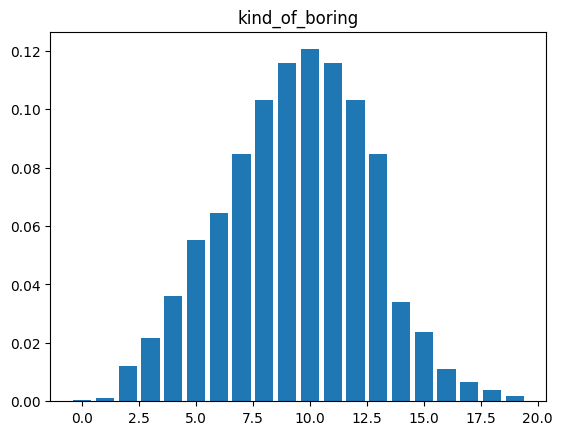

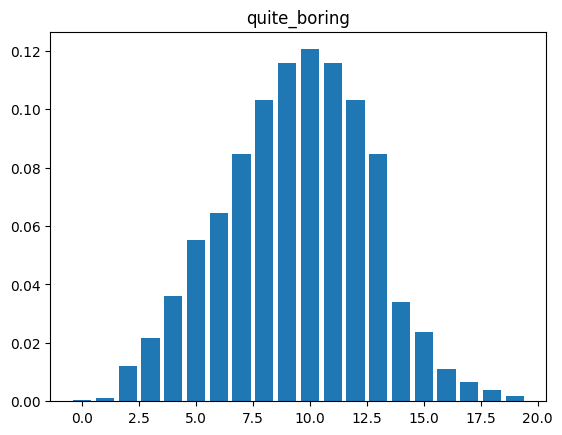

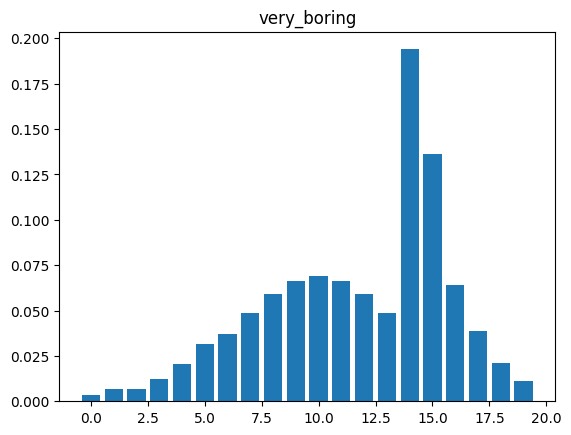

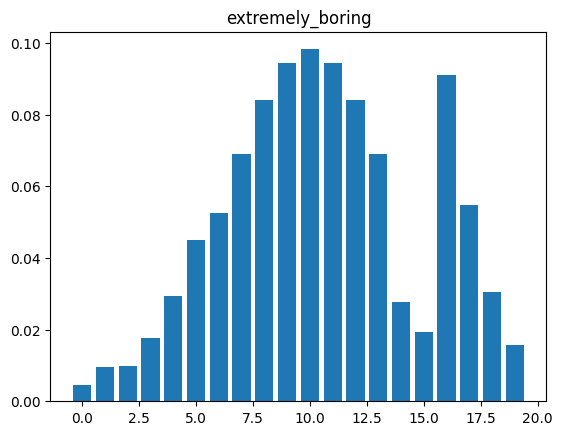

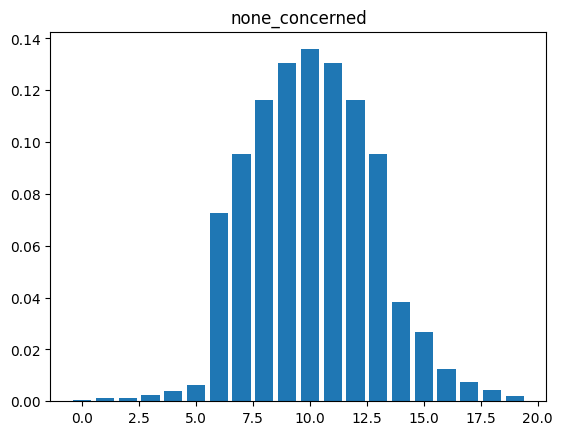

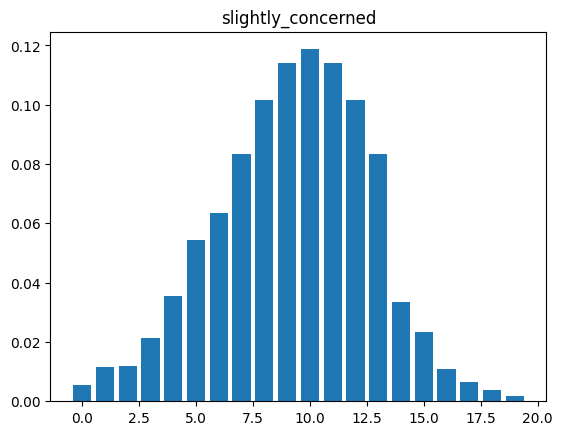

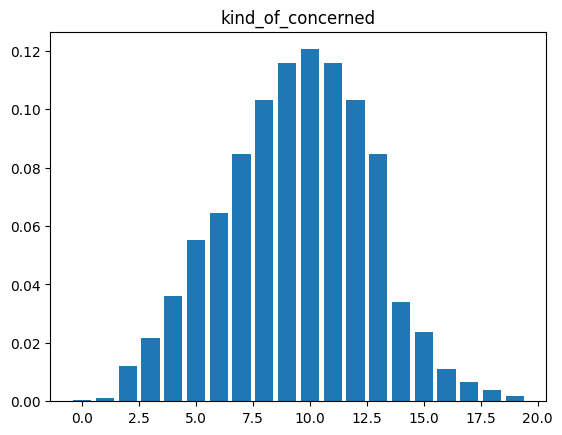

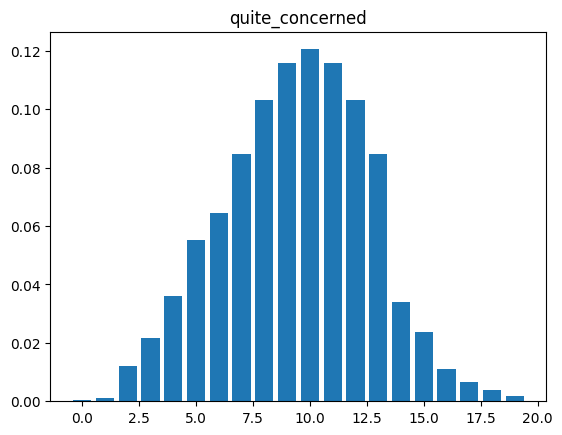

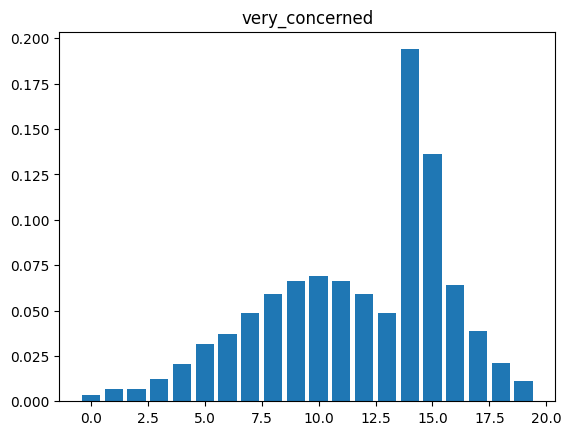

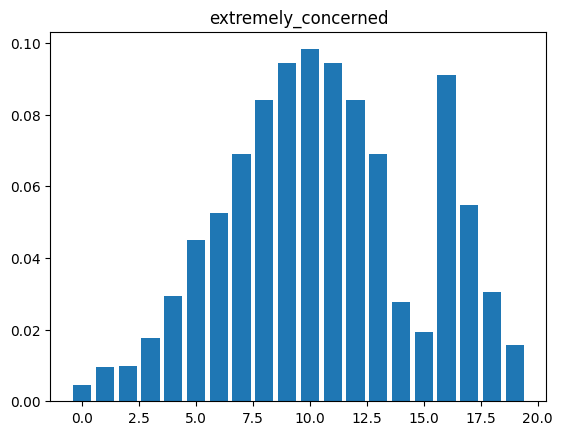

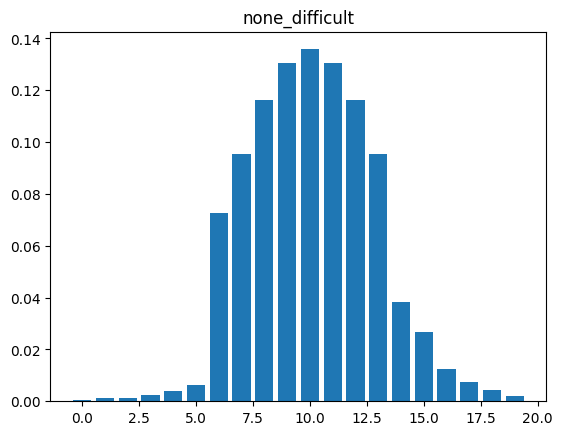

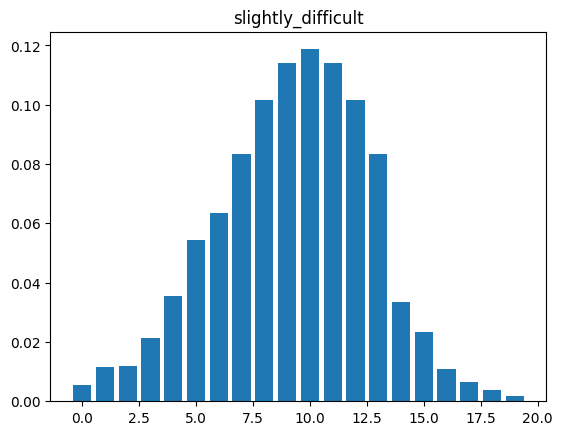

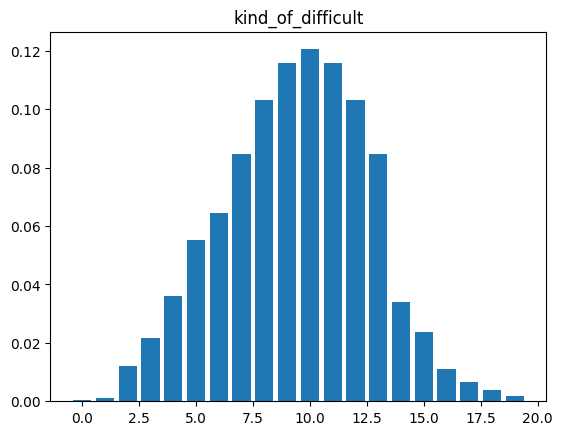

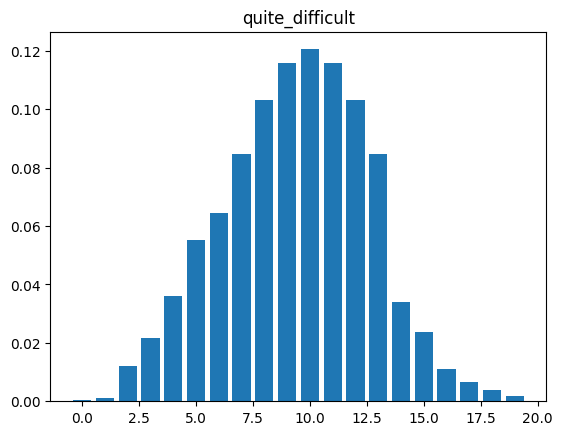

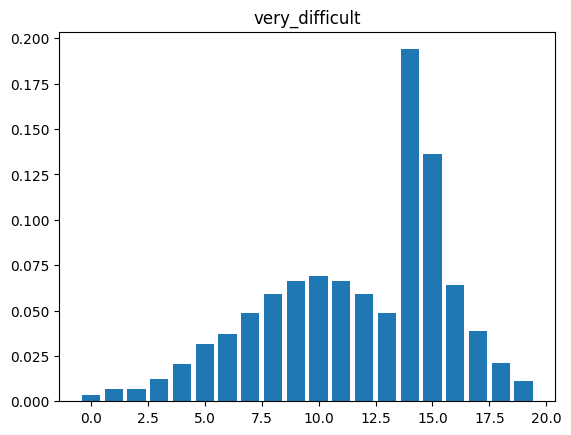

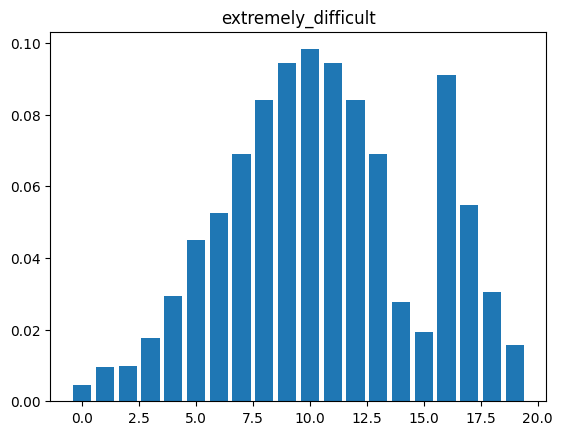

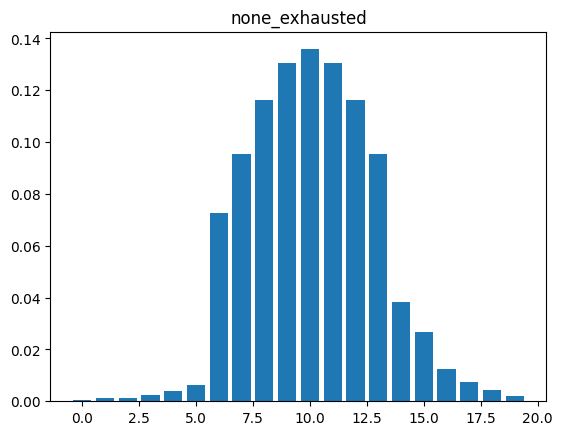

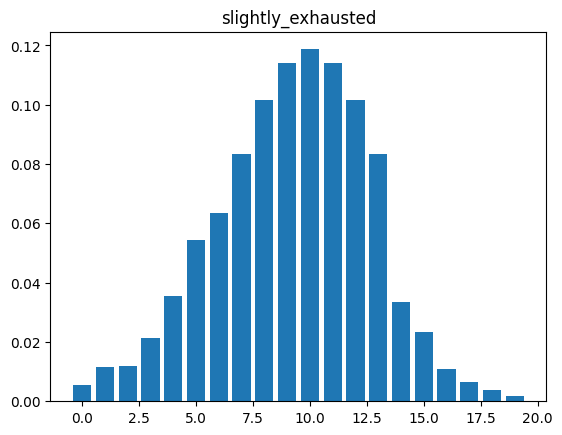

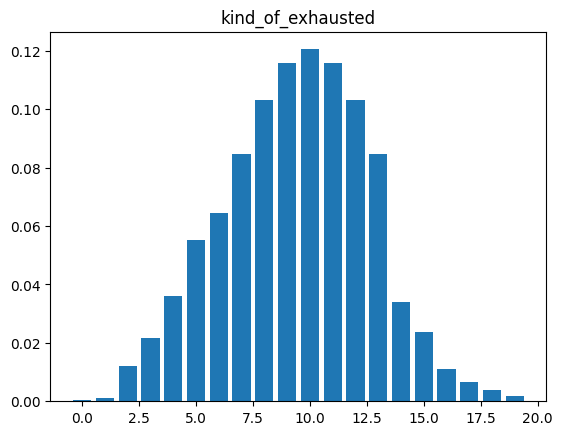

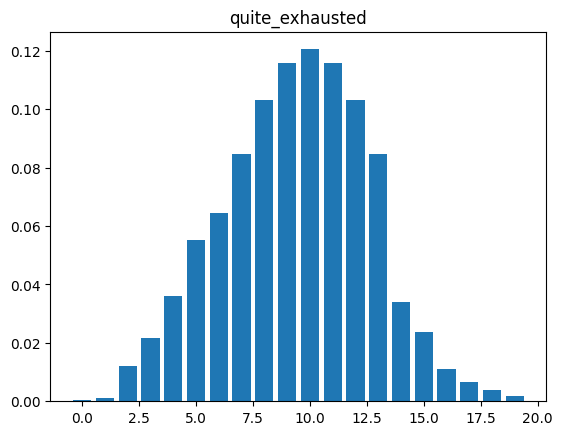

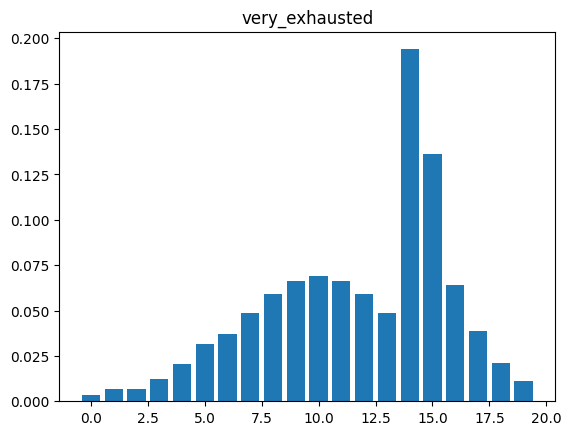

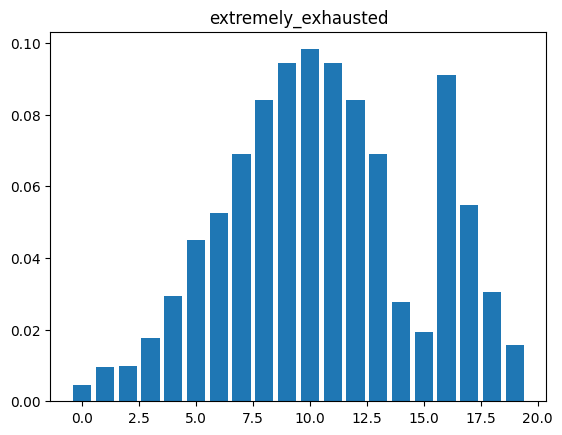

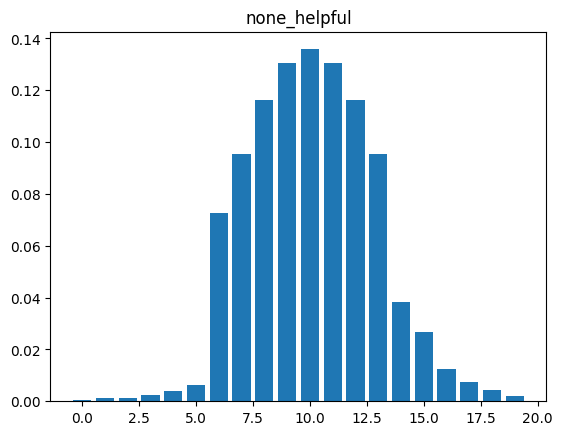

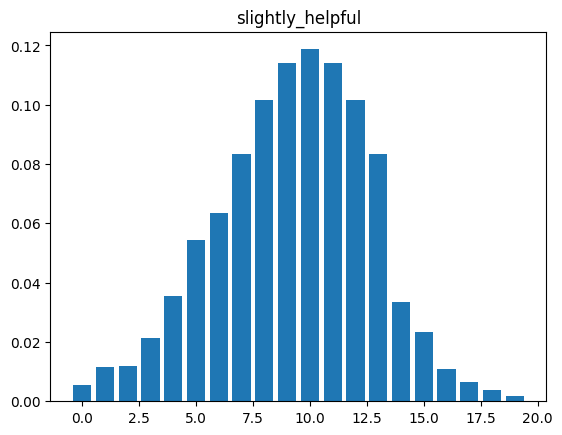

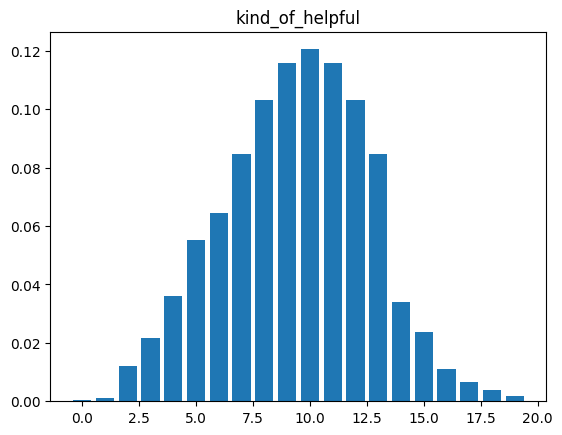

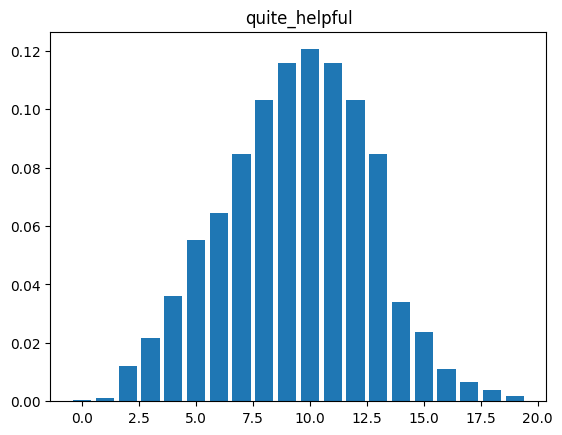

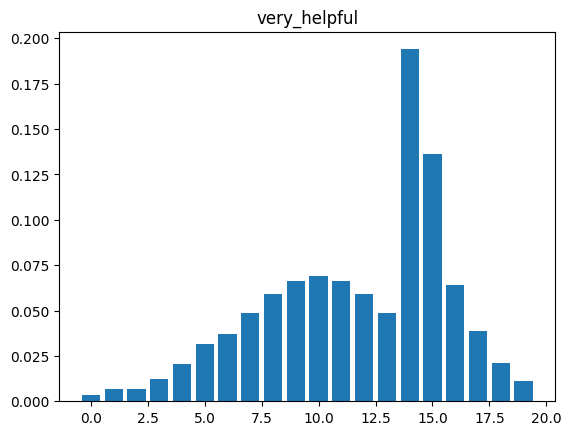

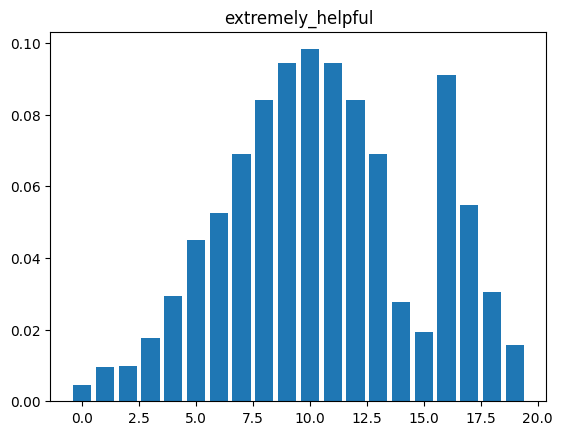

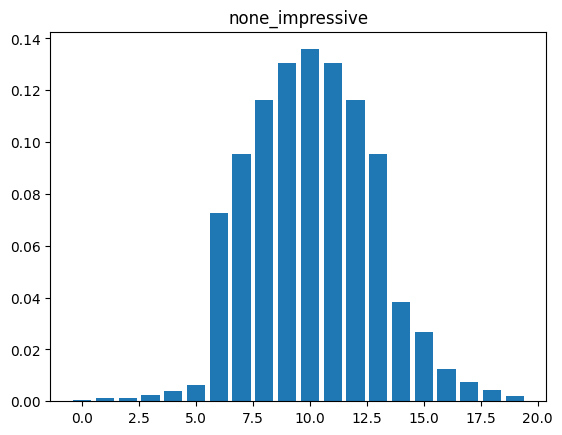

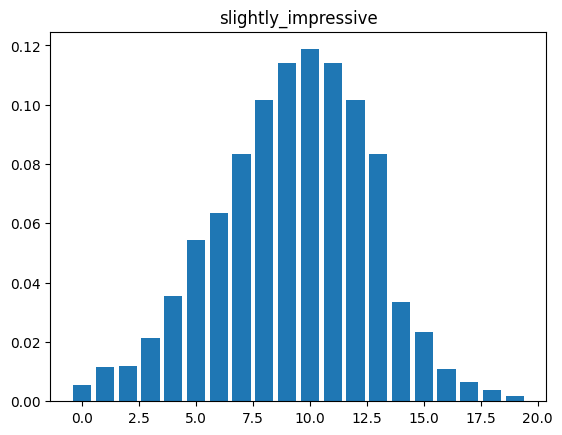

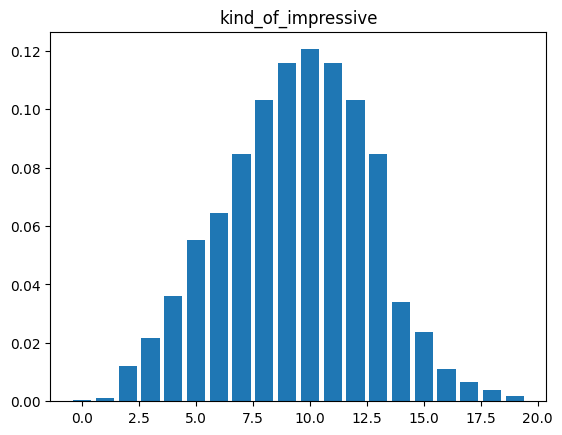

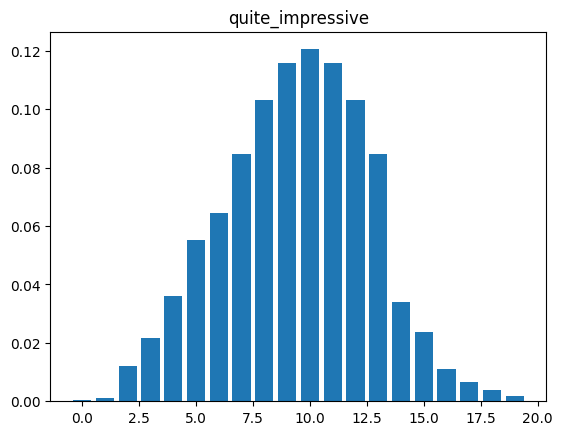

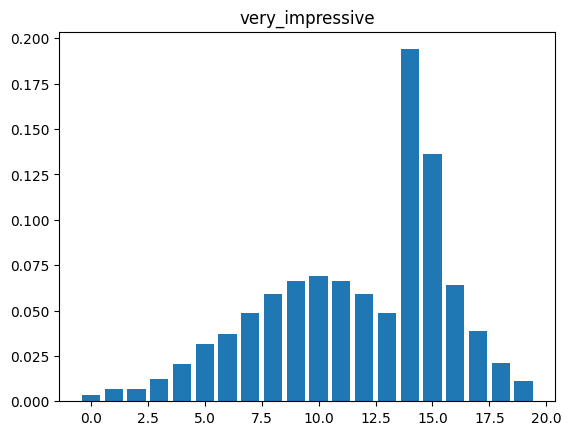

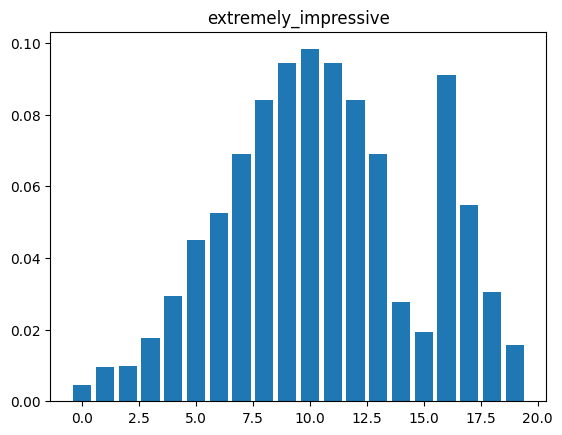

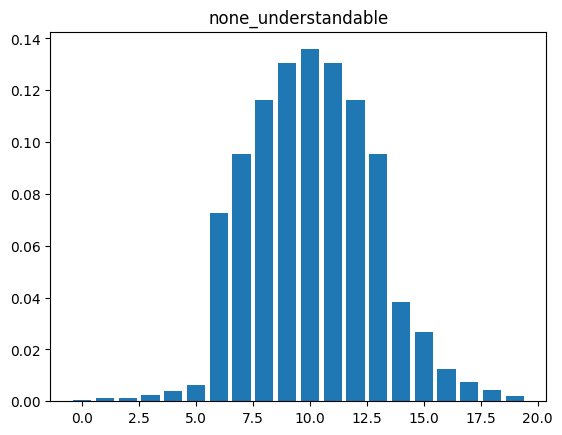

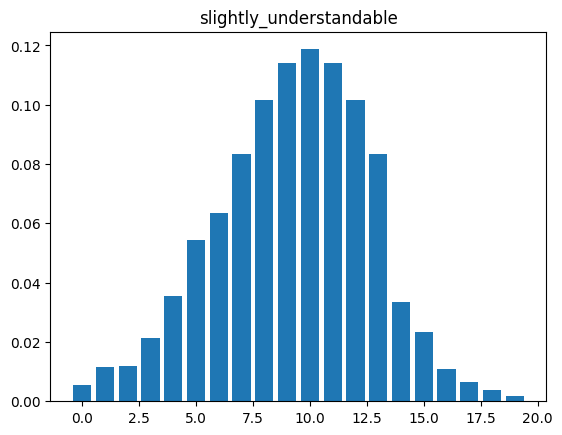

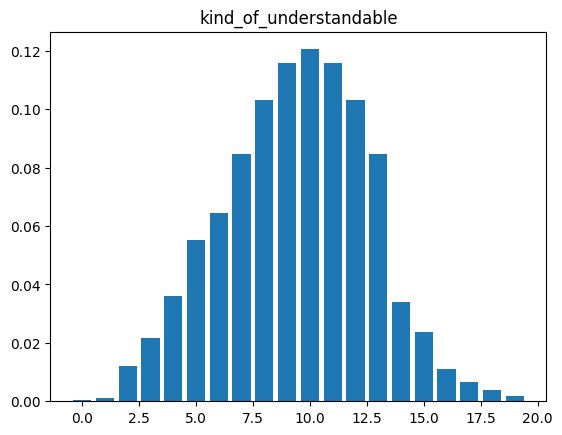

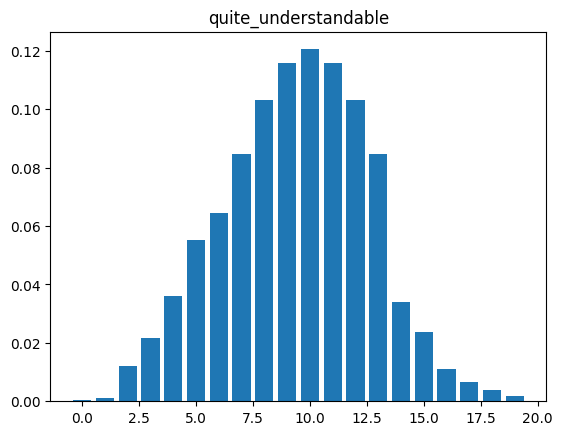

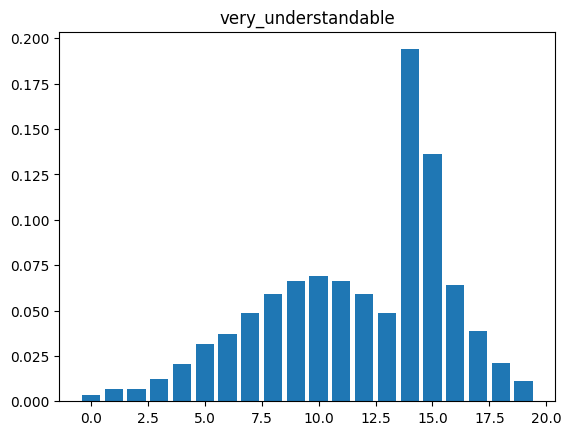

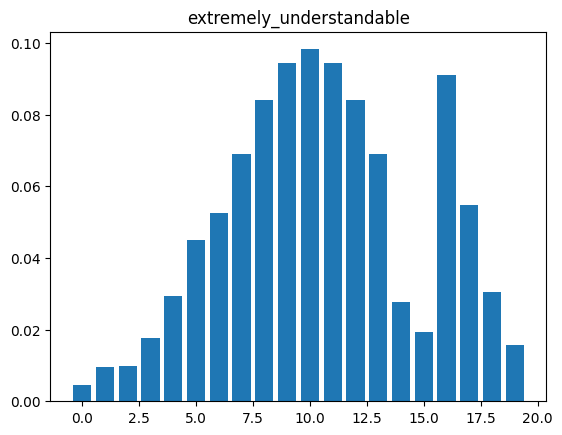

In [ ]:
import matplotlib.pyplot as plt
# specify ideal parameters.  (currently random)
thetas = [6,0,2,2,14,16] # these should be integers
cost = 0
inf_term = 0.5
soc_term = 4.5
# this is for UK version
P_l1 = UKL1(inf_term=inf_term, soc_term=soc_term, cost=cost, t0 = thetas[0],t1=thetas[1], t2= thetas[2], t3 = thetas[3], t4 = thetas[4], t5 = thetas[5]) # note this should be P(s|w)
for utterence in W:
    plt.bar(list(range(20)),P_l1[:,utterence])
    plt.title(utterence.name)
    plt.show()
    